###  Libraries

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans

from KernelKMeansPP import KernelKMeansPP
from Rings import Rings
from Common_Modules.Evaluation import Evaluator

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Global Variables

In [2]:
seed = 42
evaluator = Evaluator()

### Load Dataset

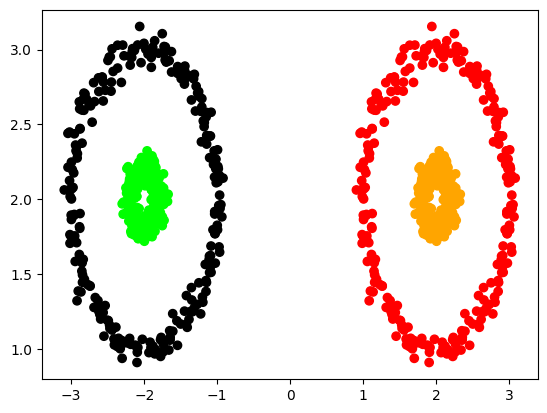

In [3]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'black', 'cyan', 'gray', 'lime']

# Generate 5 pairs of data with specified center positions and unique IDs for each ring
centers_coordinates = [(2, 2), (-2, 2)]  # Specify center positions for each pair

rings = Rings()

X, y = rings.make_rings_pairs(centers_coordinates=centers_coordinates, n_samples=500, factor=0.2, noise=0.05)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))

In [4]:
K = 4
kernel_matrix = pairwise_kernels(X, X, metric='rbf', gamma=3)

### kMeans

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikit_learn-1.3.1-py3.11-win-amd64.egg\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


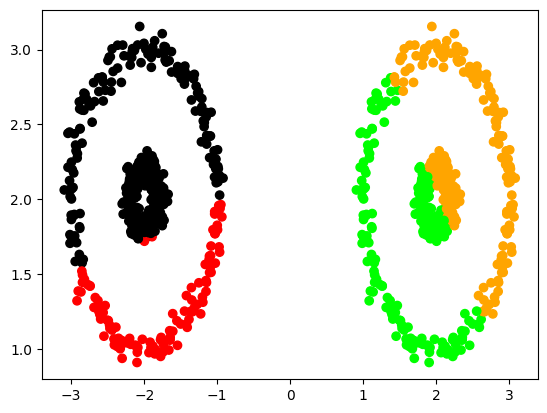

In [5]:
kmeans = KMeans(n_clusters=K).fit(X)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=ListedColormap(colors))

### Kernel kMeans

c:\Users\PAPASOFT INC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  warnings.warn(


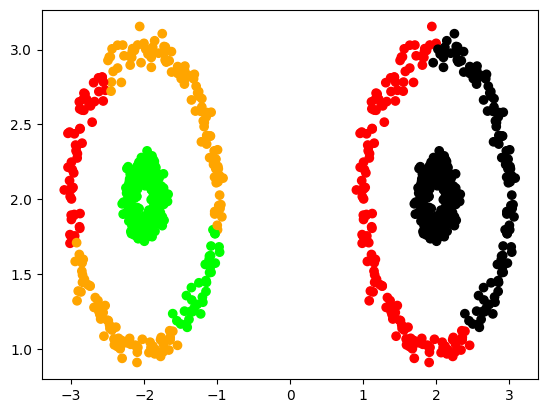

In [6]:
# Should find a way to init the fucking centers!
kernel_kmeans = KernelKMeans(n_clusters=K, n_init=1, kernel='precomputed').fit(kernel_matrix)
acc, pur, nmi, ari = evaluator.evaluate_model(y, kernel_kmeans.labels_)
evaluator.print_evaluation()
plt.scatter(X[:, 0], X[:, 1], c=kernel_kmeans.labels_, cmap=ListedColormap(colors))
plt.show()

### Kernel kMeans++

Executing KkMeans++ Initialization
Iter: 0 Cl L: 636.9691 ACC: 0.59 PUR: 0.67 NMI: 0.68 ARI: 0.52
Iter: 1 Cl L: 628.6900 ACC: 0.60 PUR: 0.69 NMI: 0.70 ARI: 0.55
Iter: 2 Cl L: 617.5830 ACC: 0.62 PUR: 0.72 NMI: 0.74 ARI: 0.59
Iter: 3 Cl L: 601.8875 ACC: 0.64 PUR: 0.75 NMI: 0.80 ARI: 0.63
Finished in Iter: 4 Cl L: 595.8754 ACC: 0.64 PUR: 0.75 NMI: 0.80 ARI: 0.63
Executing KkMeans++ Initialization
Iter: 0 Cl L: 651.0034 ACC: 0.55 PUR: 0.64 NMI: 0.62 ARI: 0.47
Iter: 1 Cl L: 634.3306 ACC: 0.62 PUR: 0.72 NMI: 0.73 ARI: 0.58
Iter: 2 Cl L: 599.3527 ACC: 0.65 PUR: 0.75 NMI: 0.80 ARI: 0.63
Iter: 3 Cl L: 595.9651 ACC: 0.65 PUR: 0.75 NMI: 0.80 ARI: 0.63
Iter: 4 Cl L: 595.9441 ACC: 0.65 PUR: 0.75 NMI: 0.80 ARI: 0.63
Finished in Iter: 5 Cl L: 595.8801 ACC: 0.65 PUR: 0.75 NMI: 0.80 ARI: 0.63
Executing KkMeans++ Initialization
Iter: 0 Cl L: 655.2367 ACC: 0.50 PUR: 0.59 NMI: 0.59 ARI: 0.44
Iter: 1 Cl L: 650.3563 ACC: 0.52 PUR: 0.62 NMI: 0.61 ARI: 0.46
Iter: 2 Cl L: 641.0687 ACC: 0.57 PUR: 0.68 NMI: 0.67

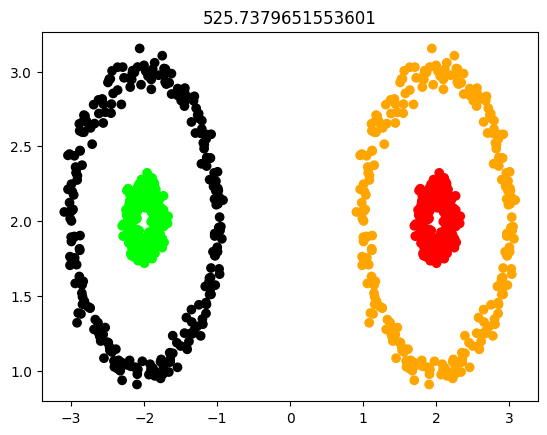

In [14]:
kernelKMeansPP =  KernelKMeansPP()
min_total_error, best_partition = kernelKMeansPP.kernel_kmeans_pp(X, y, K, kernel_matrix, n_init=10, method='KkMeans++')
plt.scatter(X[:, 0], X[:, 1], c=best_partition, cmap=ListedColormap(colors))
plt.title(min_total_error)
plt.show()